# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: rotation, digit, and everything else (slack).
To enforce this disentanglement, there are classification losses on the rotation and digit embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

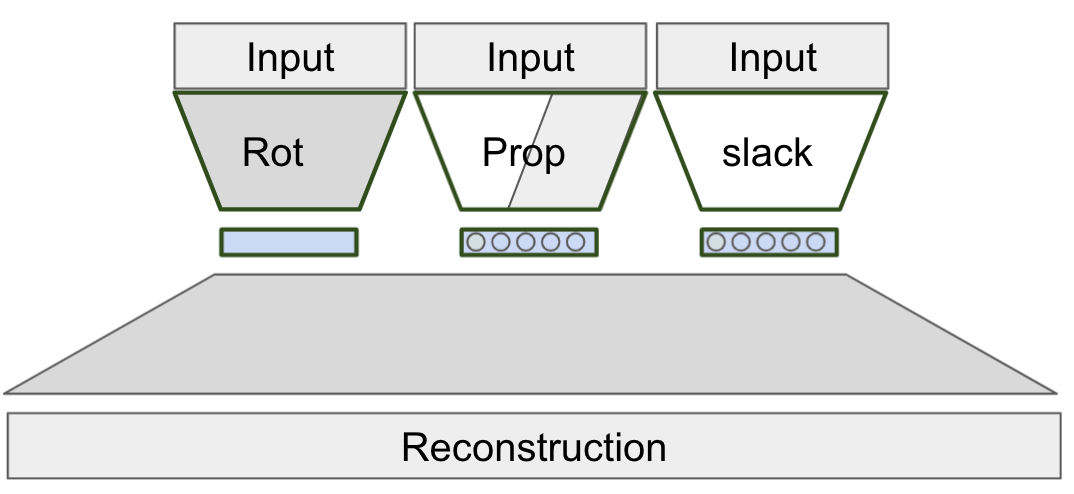


The experimental set-up is as follows:
The numbers are rotated 0, 15, 30, 45, 60, and 75 degrees. 
The model differentiates domains (rotations, referred to as *labels* in the code) from predicted values (digits, , referred to as *Y* in the code). 
The idea is to be able to provide correct labels in a new domain. 
The semi-supervision section has a new domain (30 degrees) without a Y (no digit).


This is analogous to the following situation: 
single-cell profiles where a patient or sequencing method is the domain (noise we would like to remove) and cell type (the label) is what we would like to predict.
This is done in a semi-supervised fashion because we would like to use bulk data in addition to single-cell.
However, bulk data is assumed to be a sum over many cell-types (i.e. we don't know the labels).
There is one simplification in this approach -- we predict a single-cell type for now.
Realistically, we predict a continuous vector of cell-type proportions.
Currently, we predict a 1-hot representation of cell-type identity.

Using both of these sources of data we hope that we can work on OOD stuff.
We focus on interpolation, not extrapolation, but this is not directly done in this notebook.

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# **Imports**

In [1]:
# import the our code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


# **Set up experiment parameters** 


In [2]:

n_train = 1000
batch_size = 500

# patient IDs skip "MGH85"
# patient IDs skip "BT1187"
patient_ids = ["MGH125", "MGH122", "MGH100", "MGH101", "MGH102", 
                "MGH104", "MGH105", "MGH106", "MGH110", 
                "MGH113", "MGH115", "MGH121", 
                "MGH124", "MGH128", "MGH129", 
                "MGH136", "MGH143", "MGH151", "MGH152", 
                "BT749", "BT771", "BT786", "BT830", 
                "BT920", "BT1160"]



### create the domains label 
Label_full = np.concatenate([np.full(n_train, i) for i in range(25)], axis=0)
label_full = to_categorical(Label_full)


# indexes for the training/testing
idx_train_sm2 = np.where(np.logical_and(Label_full!=2, Label_full!=0))[0]
idx_3_sm2 = np.where(Label_full==2)[0]
idx_0_sm2 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=0))[0]
idx_3 = np.where(Label_full==2)[0]
idx_0 = np.where(Label_full==0)[0]


# **Load Data**

In [3]:

res_path = f"{os.getcwd()}/../../results/single_cell_data/diva_gbm28/"
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_gbm28/"
cs_res_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_gbm28/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_gbm28_data/"

def read_gene_file(res_path):
    gene_file = os.path.join(res_path, f"train-gbm28-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train

# read in all the expression data used
X_train_all = []
Y_train_all = []
for curr_id in patient_ids:
    X_train, Y_train, _, _ = sc_preprocess.read_diva_files(data_path, None, curr_id)
    Y_train.reindex(columns=['Malignant', 'Macrophage', 'T-cell', 'Oligodendrocyte'], fill_value=0)
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_train = pd.concat(X_train_all, ignore_index=True)
Y_train = pd.concat(Y_train_all, ignore_index=True)
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

gbm28_enc = tf.keras.models.load_model(f"{res_path}/encoder")
gbm28_train = read_gene_file(res_path)


2021-11-16 16:39:05.275851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Make TSNE of raw and training data**

In [4]:
def make_tsne_fig(X_df, color_vec, ax, title):
    ## plot samples
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X_df)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    plot_df['class'] = color_vec

    n_colors = len(np.unique(color_vec))
    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="class",
        palette=sns.color_palette("hls", n_colors),
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.024s...
[t-SNE] Computed neighbors for 1000 samples in 0.222s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 58042978.816850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.964256
[t-SNE] KL divergence after 300 iterations: 0.630882
(1000, 2)
(1000, 2)


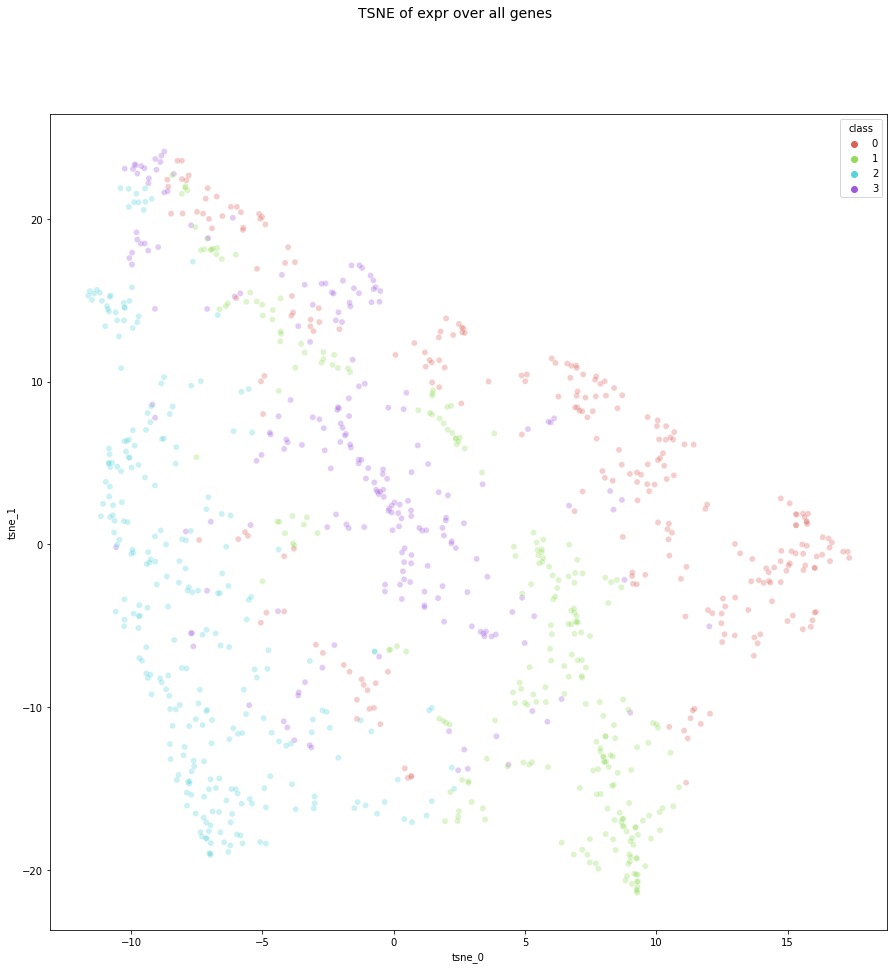

In [5]:
# plot over all genes

curr_idx = idx_0

fig, axs = plt.subplots(1, 1, figsize=(15,15))
tmp_Y = Y_train.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(X_train.iloc[curr_idx], tmp_Y, ax=axs, title="")

fig.suptitle("TSNE of expr over all genes", fontsize=14)

fig.show()

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 58014239.226535
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.955231
[t-SNE] KL divergence after 300 iterations: 0.628490
(1000, 2)
(1000, 2)


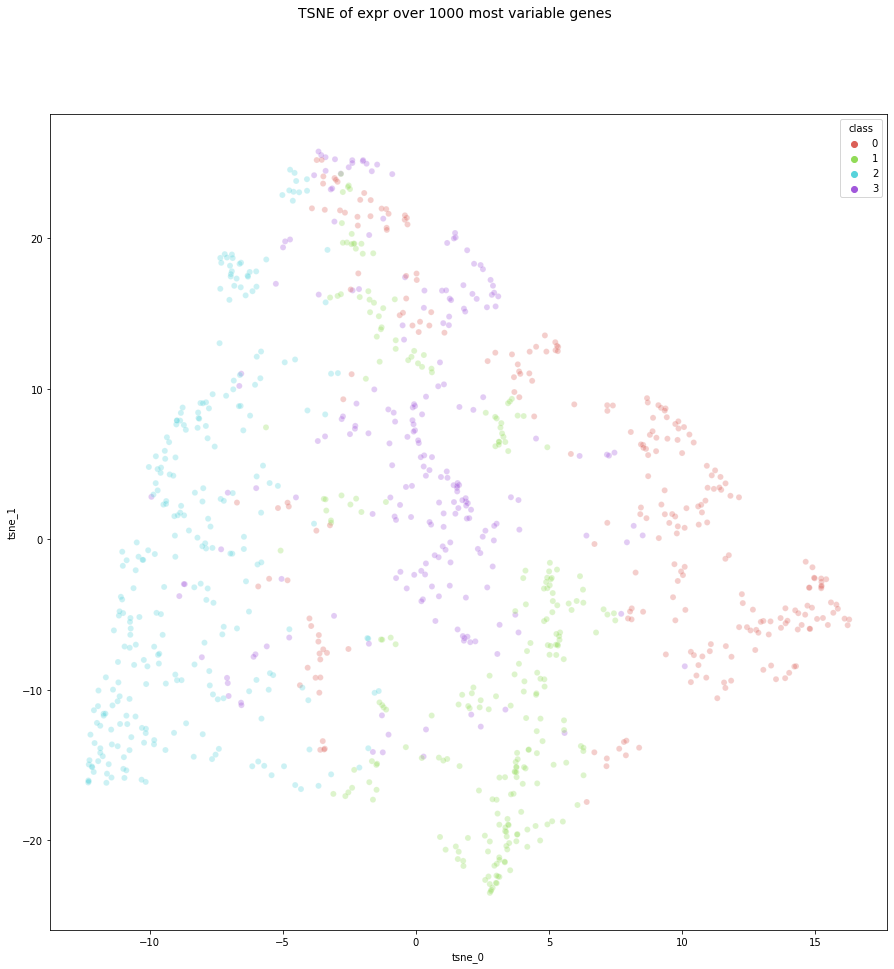

In [6]:
# plot over only genes used in testing

curr_idx = idx_0

fig, axs = plt.subplots(1, 1, figsize=(15,15))
tmp_Y = Y_train.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)

tmp_X = X_train[gbm28_train["gene_ids"]]

make_tsne_fig(tmp_X.iloc[curr_idx], tmp_Y, ax=axs, title="")

fig.suptitle("TSNE of expr over 1000 most variable genes", fontsize=14)
fig.show()


# **Plot Loss Curves**

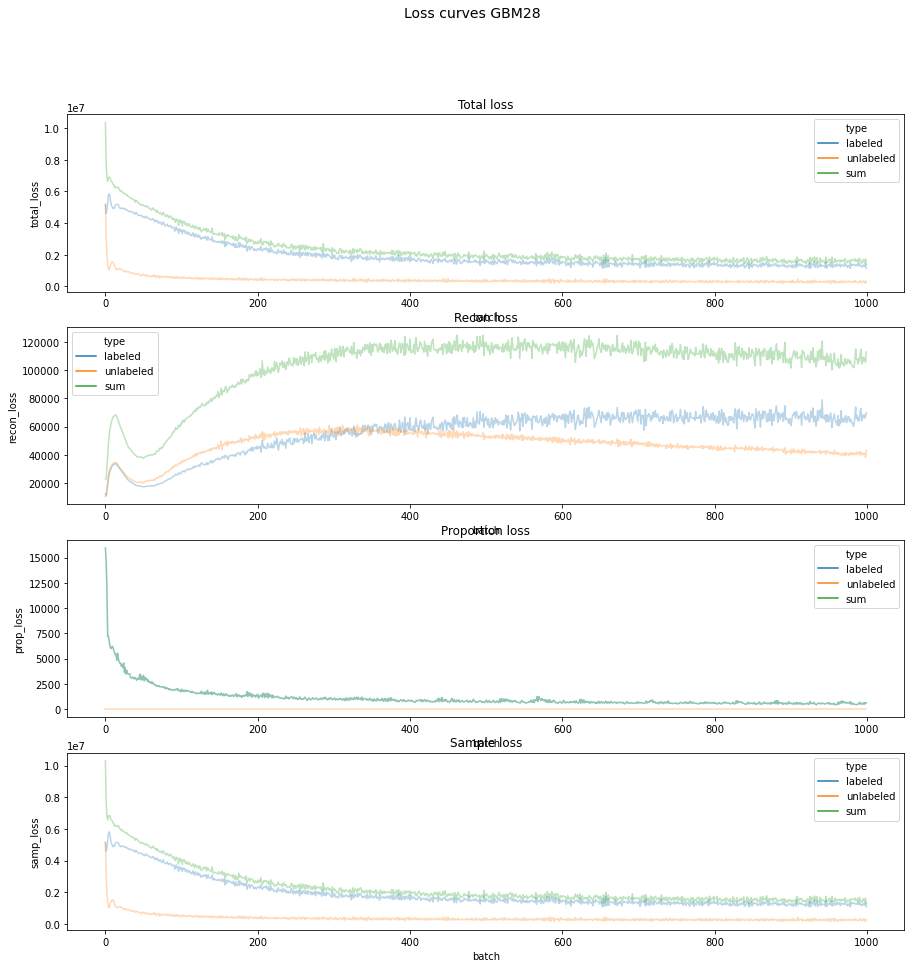

In [7]:
def read_loss_file(res_path):
    loss_file = os.path.join(res_path, f"train-gbm28-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g




fig, axs = plt.subplots(4,1, figsize=(15,15))
loss_df1 = read_loss_file(res_path)
make_loss_fig(loss_df1, ax=axs[0], title="Total loss", loss_to_plot="total_loss")
make_loss_fig(loss_df1, ax=axs[1], title="Recon loss", loss_to_plot="recon_loss")
make_loss_fig(loss_df1, ax=axs[2], title="Proportion loss", loss_to_plot="prop_loss")
make_loss_fig(loss_df1, ax=axs[3], title="Sample loss", loss_to_plot="samp_loss")

fig.suptitle("Loss curves GBM28", fontsize=14)

fig.show()




In [8]:
loss_df1

,total_loss,type,batch,recon_loss,prop_loss,samp_loss
0,5154017.000,labeled,0,12297.433594,15972.720703,5125747.000
1,4616582.000,labeled,1,10843.326172,14681.335938,4591057.500
2,4823906.000,labeled,2,14206.366211,11853.472656,4797846.000
3,5258098.500,labeled,3,18817.025391,7186.349609,5232095.000
4,5768606.500,labeled,4,22918.121094,7216.758789,5738471.500
...,...,...,...,...,...,...
2995,1704624.625,sum,995,106202.171875,506.918335,1597915.500
2996,1644263.750,sum,996,109057.218750,637.992188,1534568.500
2997,1469404.500,sum,997,106990.093750,479.699463,1361934.625
2998,1737282.250,sum,998,105570.367188,631.898804,1631080.000


# **Plot Encodings**

## TSNE on training data

Here we are now interested in training on pbmc_rep1_10xV2a and testing on other settings.
So we will first show how well we perform on our training data

In [9]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g



Number unique Y: 4
X_temp: (23000, 1000)
Y_temp: [3 2 0 ... 0 3 1]


2021-11-16 16:39:21.515221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 23000 samples in 0.002s...
[t-SNE] Computed neighbors for 23000 samples in 23.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23000
[t-SNE] Computed conditional probabilities for sample 2000 / 23000
[t-SNE] Computed conditional probabilities for sample 3000 / 23000
[t-SNE] Computed conditional probabilities for sample 4000 / 23000
[t-SNE] Computed conditional probabilities for sample 5000 / 23000
[t-SNE] Computed conditional probabilities for sample 6000 / 23000
[t-SNE] Computed conditional probabilities for sample 7000 / 23000
[t-SNE] Computed conditional probabilities for sample 8000 / 23000
[t-SNE] Computed conditional probabilities for sample 9000 / 23000
[t-SNE] Computed conditional probabilities for sample 10000 / 23000
[t-SNE] Computed conditional probabilities for sample 11000 / 23000
[t-SNE] Computed conditional probabilities for sample 12000 / 23000
[t-SNE] Computed conditional probabilities for s

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 23000 samples in 0.002s...
[t-SNE] Computed neighbors for 23000 samples in 22.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23000
[t-SNE] Computed conditional probabilities for sample 2000 / 23000
[t-SNE] Computed conditional probabilities for sample 3000 / 23000
[t-SNE] Computed conditional probabilities for sample 4000 / 23000
[t-SNE] Computed conditional probabilities for sample 5000 / 23000
[t-SNE] Computed conditional probabilities for sample 6000 / 23000
[t-SNE] Computed conditional probabilities for sample 7000 / 23000
[t-SNE] Computed conditional probabilities for sample 8000 / 23000
[t-SNE] Computed conditional probabilities for sample 9000 / 23000
[t-SNE] Computed conditional probabilities for sample 10000 / 23000
[t-SNE] Computed conditional probabilities for sample 11000 / 23000
[t-SNE] Computed conditional probabilities for sample 12000 / 23000
[t-SNE] Computed conditional probabilities for s

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Indexed 23000 samples in 0.014s...
[t-SNE] Computed neighbors for 23000 samples in 0.904s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23000
[t-SNE] Computed conditional probabilities for sample 2000 / 23000
[t-SNE] Computed conditional probabilities for sample 3000 / 23000
[t-SNE] Computed conditional probabilities for sample 4000 / 23000
[t-SNE] Computed conditional probabilities for sample 5000 / 23000
[t-SNE] Computed conditional probabilities for sample 6000 / 23000
[t-SNE] Computed conditional probabilities for sample 7000 / 23000
[t-SNE] Computed conditional probabilities for sample 8000 / 23000
[t-SNE] Computed conditional probabilities for sample 9000 / 23000
[t-SNE] Computed conditional probabilities for sample 10000 / 23000
[t-SNE] Computed conditional probabilities for sample 11000 / 23000
[t-SNE] Computed conditional probabilities for sample 12000 / 23000
[t-SNE] Computed conditional probabilities for sample 13000 / 23000
[t-SNE] Computed conditi

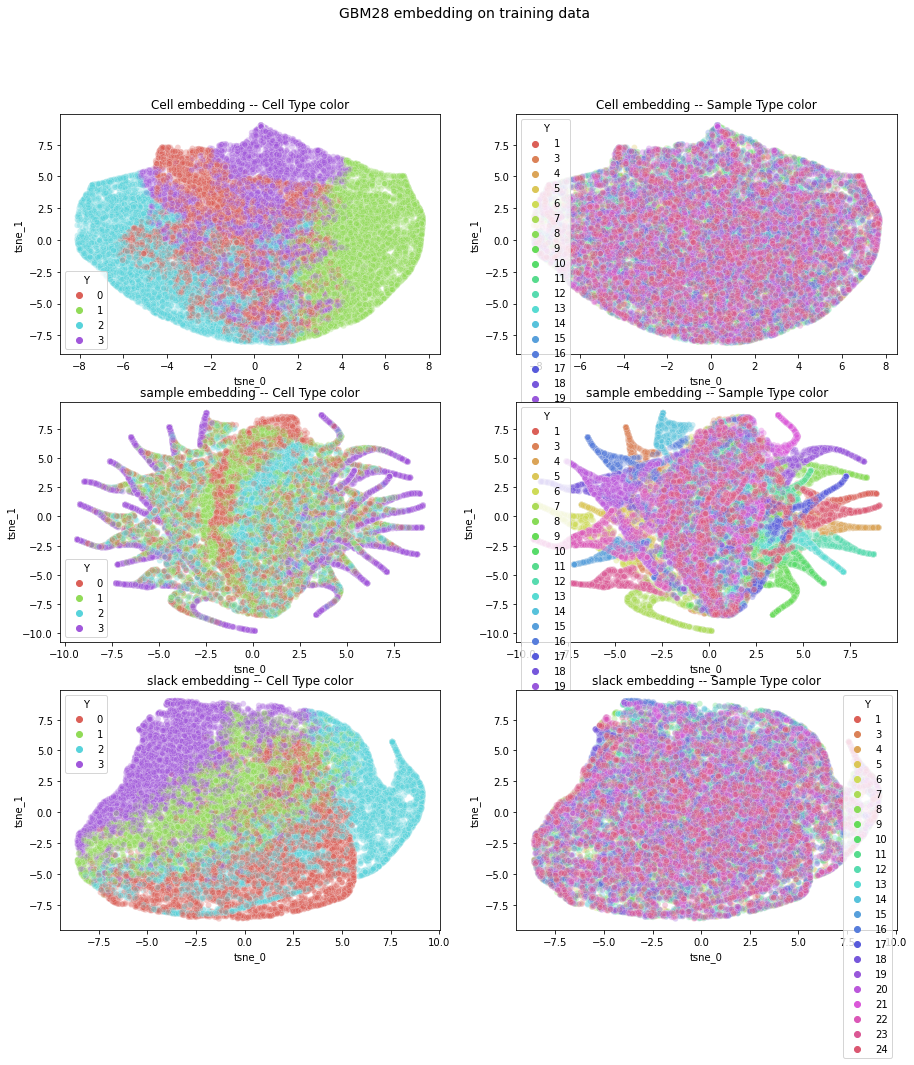

In [10]:

# plot proportions on the held out sample
X_temp = X_train[gbm28_train["gene_ids"]]
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_train]
X_temp = np.asarray(X_temp).astype(np.float32)

Y_temp = Y_train
Y_temp = np.argmax(Y_temp.to_numpy(), axis=1)
Y_temp = Y_temp[idx_train]

label_temp = Label_full[idx_train]


print(f"Number unique Y: {len(np.unique(Y_temp))}")
print(f"X_temp: {X_temp.shape}")
print(f"Y_temp: {Y_temp}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = gbm28_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(3, 2, figsize=(15,15))
plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")


fig.suptitle("GBM28 embedding on training data", fontsize=14)

fig.show()



# **Predict on our noise**

## Predict on unseen data

In [11]:
def read_diva_result_file(res_path, test_id):
    res_file = os.path.join(res_path, f"test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, test_id):
    res_file = os.path.join(res_path, f"test-{test_id}_0-bp_1000_prop.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [12]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df

In [13]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

First test only on re-sampled noise

MSqE mean: 0.0031385798320440095, median: 0.0009490895034702444, max: 0.026039718761380826
Spearman mean: 0.8710330253221977, median: 1.0, max: 1.0
Pearson mean: 0.9805077590620092, median: 0.9933852559712373, max: 0.9999974394280907
MSqE mean: 0.003378552345145296, median: 0.0010457556277633394, max: 0.026993068374743374
Spearman mean: 0.9066438438328757, median: 1.0, max: 1.0
Pearson mean: 0.9800397304658861, median: 0.9949553280803998, max: 0.9999999584504411


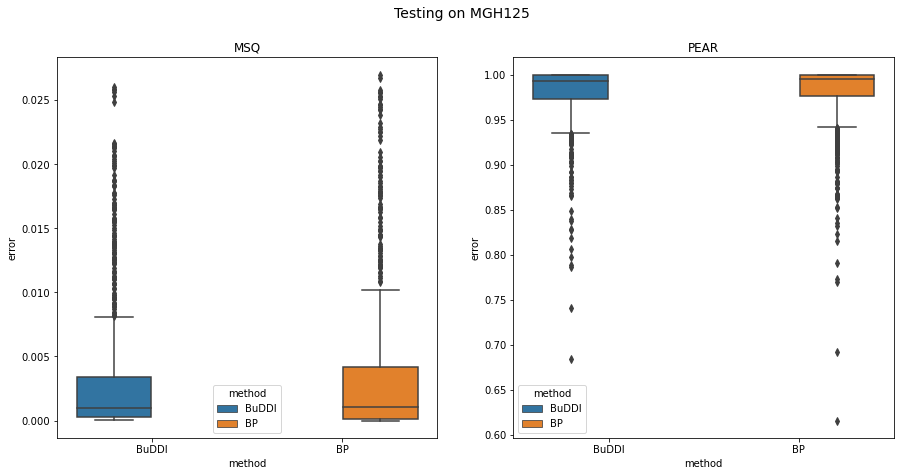

In [14]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "MGH125")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "MGH125")

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, None, "MGH125")
Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

within_sample_test_bp = within_sample_test_bp[within_sample_test_diva.columns]

within_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
within_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
within_diva_err["method"] = ["BuDDI"]*within_diva_err.shape[0]
within_bp_err["method"] = ["BP"]*within_bp_err.shape[0]

plot_df = pd.concat([within_diva_err, within_bp_err])
#plot_df = within_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Testing on MGH125", fontsize=14)

fig.show()

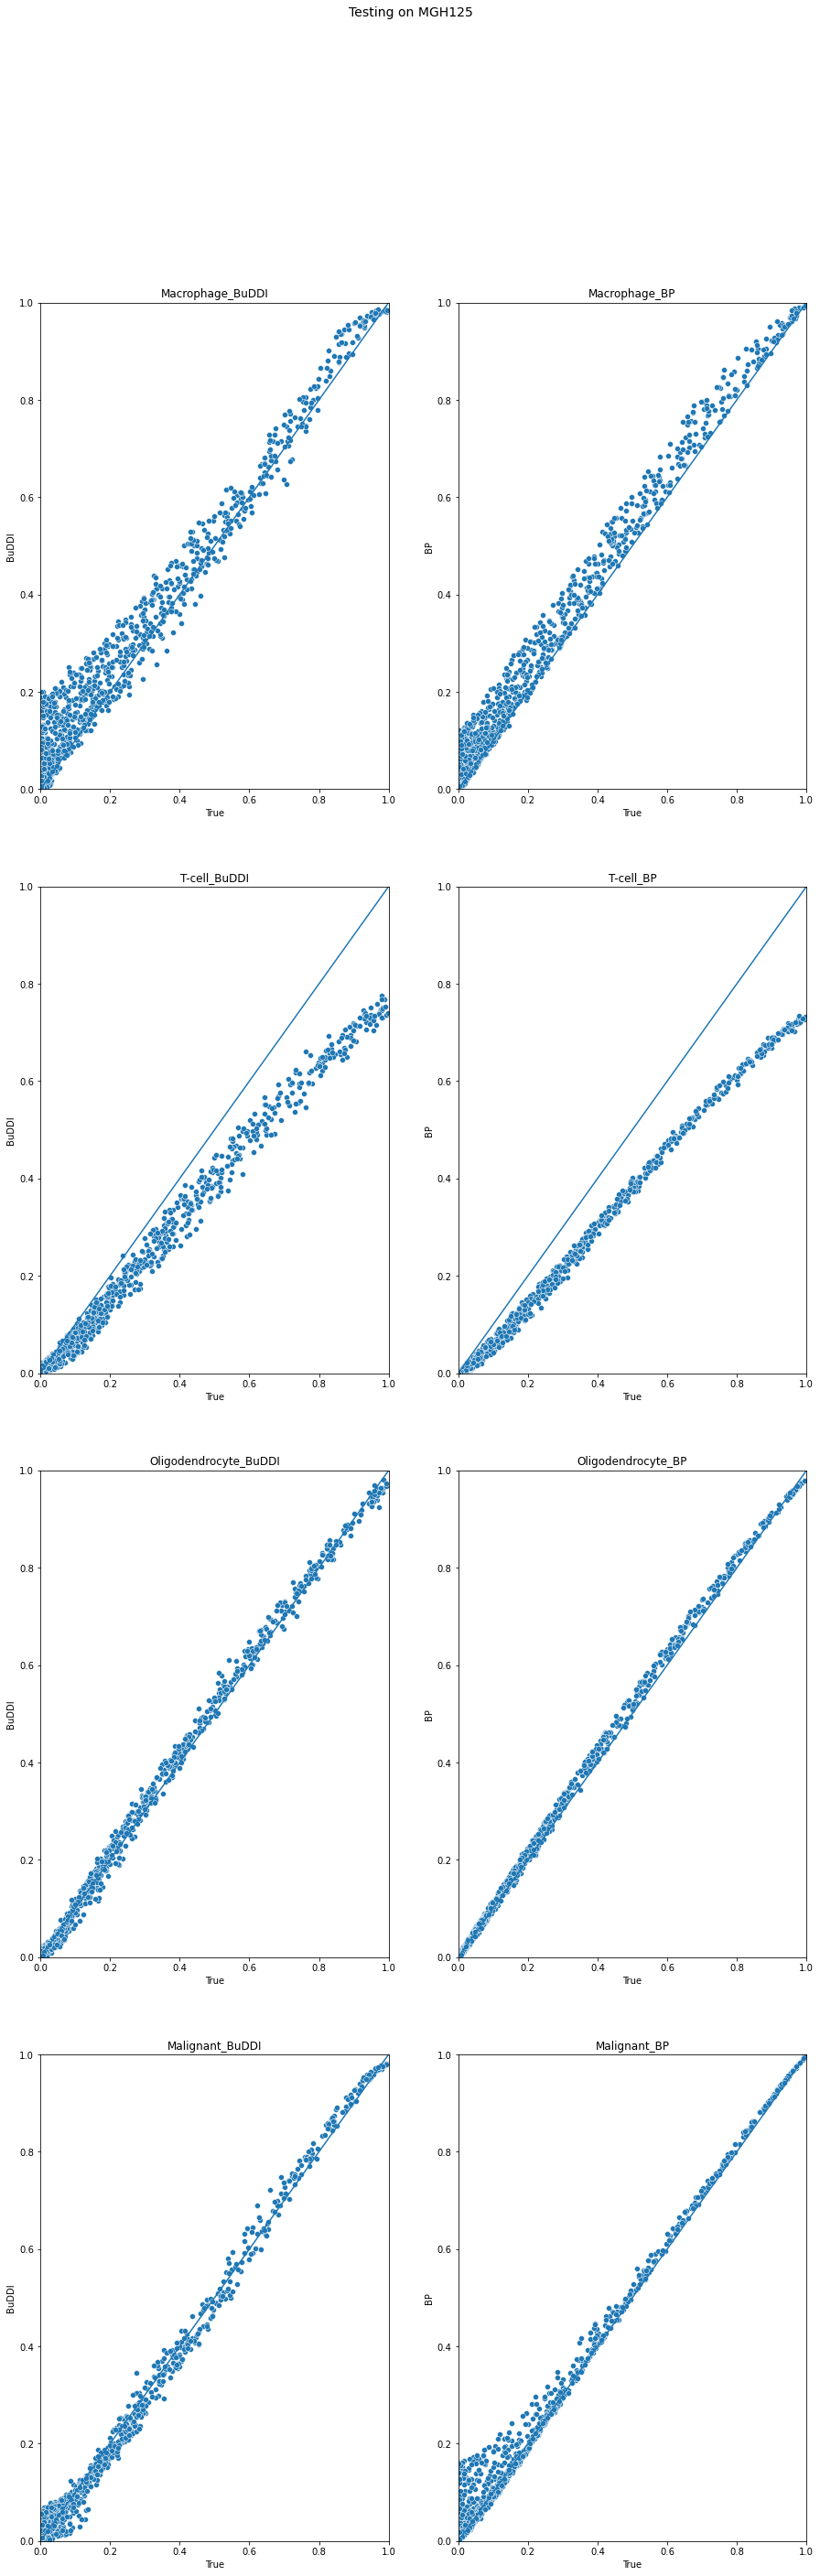

In [15]:

fig, axs = plt.subplots(4, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Testing on MGH125", fontsize=14)

fig.show()

